- [18.1 - Multiple Linear Regression](#18.1---Multiple-Linear-Regression)

## Chapter 18 - Metric Predicted Variable with Multiple Metric Predictors

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from scipy.stats import mode, norm, t
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [47]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, point_est='mode', burnin=0, y_labels=False, ax=None):
       
    color = '#87ceeb'
    font_d = {'size':14}
    
    if ax == None:
        ax = plt.gca()
               
    hpd_interval = np.round(pmc.hpd(dist[burnin:], alpha=alpha), decimals=decimals)

    # Histogram, Mode/Mean
    sns.distplot(dist[burnin:], kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    
    if point_est == 'mode':
        p_est_value = mode(np.round(dist[burnin:], decimals=decimals))[0][0]
    else:
        p_est_value = np.round(np.mean(dist[burnin:]), decimals=decimals)
    
    ax.text(p_est_value, plot_height*.9, '{} = {}'.format(point_est, p_est_value),
            horizontalalignment='center', fontdict=font_d, clip_on=False)    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict=font_d)
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict=font_d)

    # Reference line
    if vert_ref is None:
        ax.axvline(p_est_value, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

### 18.1 - Multiple Linear Regression
#### Data

In [48]:
df = pd.read_csv('data/Guber1999data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
State        50 non-null object
Spend        50 non-null float64
StuTeaRat    50 non-null float64
Salary       50 non-null float64
PrcntTake    50 non-null int64
SATV         50 non-null int64
SATM         50 non-null int64
SATT         50 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [49]:
df.head()

        State  Spend  StuTeaRat  Salary  PrcntTake  SATV  SATM  SATT
0     Alabama  4.405       17.2  31.144          8   491   538  1029
1      Alaska  8.963       17.6  47.951         47   445   489   934
2     Arizona  4.778       19.3  32.175         27   448   496   944
3    Arkansas  4.459       17.1  28.934          6   482   523  1005
4  California  4.992       24.0  41.078         45   417   485   902

In [88]:
X = df[['Spend', 'PrcntTake']]
y = df['SATT']

meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

meany = y.mean()
scaley = y.std()
zy = ((y-meany)/scaley).values

#### Model (Kruschke, 2015)

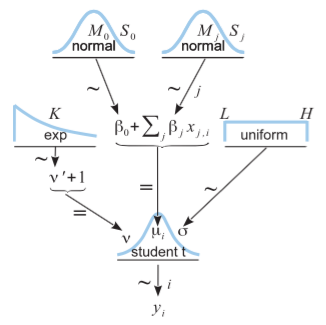

In [6]:
Image('images/fig18_4.png', width=400)

In [89]:
with pmc.Model() as model:
    
    zbeta0 = pmc.Normal('zbeta0', mu=0, sd=2)
    zbetaj = pmc.Normal('zbetaj', mu=0, sd=2, shape=(2))
    zmu =  zbeta0 + zbetaj[0]*zX[:,0] + zbetaj[1]*zX[:,1]
    #zmu =  zbeta0 + zbetaj*zX
        
    nu = pmc.Exponential('nu', 1/29.)
    zsigma = pmc.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pmc.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

Applied log-transform to nu and added transformed nu_log_ to model.
Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [110]:
with model:
    trace = pmc.sample(3000)

Assigned NUTS to zbeta0
Assigned NUTS to zbetaj
Assigned NUTS to nu_log_
Assigned NUTS to zsigma_interval_
 [-----------------100%-----------------] 3000 of 3000 complete in 31.1 sec

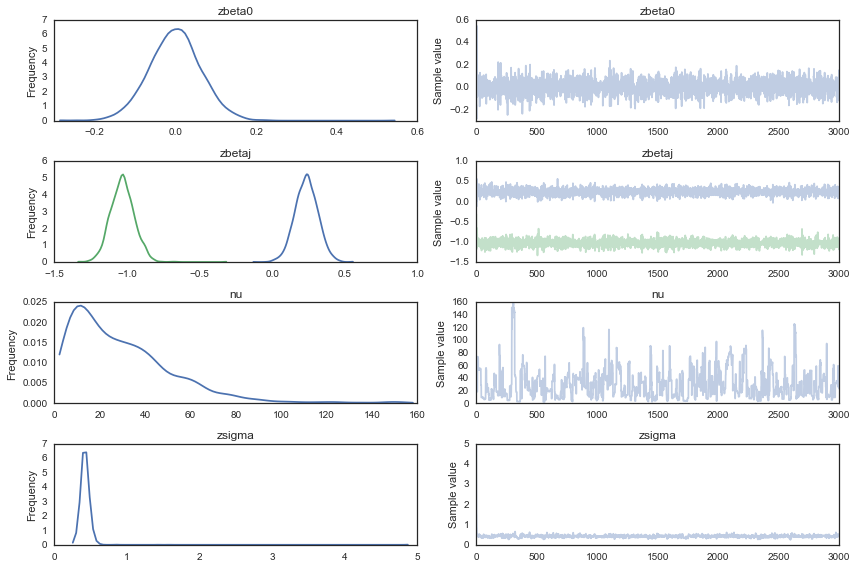

In [111]:
pmc.traceplot(trace);

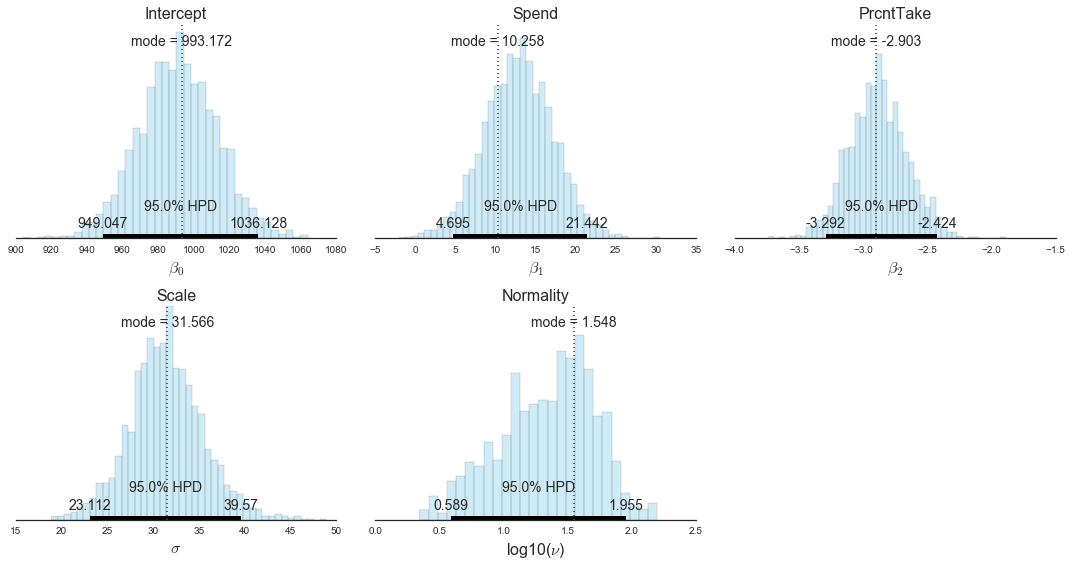

In [112]:
# Transform parameters back to original scale
beta0 = trace['zbeta0']*scaley + meany - np.sum(trace['zbetaj']*meanx/scalex, axis=1)*scaley
betaj = (trace['zbetaj']/scalex)*scaley
scale = trace['zsigma']*scaley

intercept = beta0
spend = betaj[:,0]
prcnttake =  betaj[:,1]
normality = np.log10(trace['nu'])
burnin = 100

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(15,8))

plot_posterior(intercept[burnin:], ax=ax1)
ax1.set_title('Intercept', fontdict=f_dict)
ax1.set_xlabel(r'$\beta_0$', fontdict=f_dict)

plot_posterior(spend[burnin:], ax=ax2)
ax2.set_title('Spend', fontdict=f_dict)
ax2.set_xlabel(r'$\beta_1$', fontdict=f_dict)

plot_posterior(prcnttake[burnin:], ax=ax3)
ax3.set_title('PrcntTake', fontdict=f_dict)
ax3.set_xlabel(r'$\beta_2$', fontdict=f_dict)

plot_posterior(scale[burnin:], ax=ax4)
ax4.set_title('Scale', fontdict=f_dict)
ax4.set_xlabel(r'$\sigma$', fontdict=f_dict)

plot_posterior(normality[burnin:], ax=ax5)
ax5.set_title('Normality', fontdict=f_dict)
ax5.set_xlabel(r'log10($\nu$)', fontdict=f_dict)

plt.tight_layout()

ax6.set_visible(False)

Below we create the scatterplots of figure 18.5 using `pairplot()` in seaborn and then tweak the lower triangle.

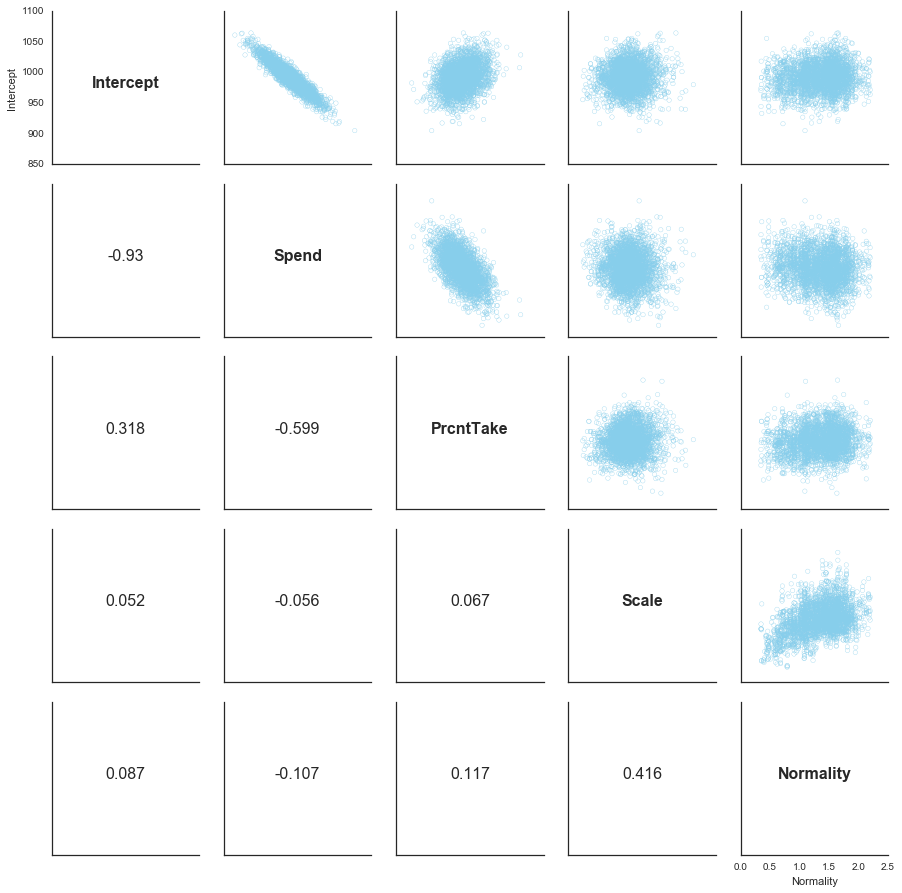

In [116]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept,
                         'Spend':spend,
                         'PrcntTake': prcnttake,
                         'Scale':scale,
                         'Normality': normality},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt.iloc[burnin:,:], rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt.iloc[burnin:,:], plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')